<h1 style='font-family:TimesNewRoman'>Product Classification with CNNs</h1> 

<div style='text-align: justify; font-family:TimesNewRoman'>
This notebook follows the development of a neural network for classification of smartphone pictures of products found in grocery stores. It's divided in three sections:
    <ol>
        <li>
            Implementation of a neural network form scratch, as well as its progressive refinment until an accuracy on the validation dataset of at least 70% is achieved
        </li>
        <li>
            The fine-tuning of a pre-trained network provided by Keras until an accuracy on the validation dataset of at least 90% is achieved      
        </li>
        <li>
              A side-by-side comparison of the performance of the two networks through the test dataset   
        </li>
    </ol>
</div>

<h2 style='font-family:TimesNewRoman'>Dataset</h2> 

<div style='text-align: justify; font-family:TimesNewRoman'>
    The dataset has been retreived from the following <a href="https://github.com/marcusklasson/GroceryStoreDataset.git">gitHub repository</a>. The dataset is already split into training, testing and validation. It contains about 5125 natural pictures of different classes of fruits, vegetables and packaged items. Each picture is labelled through both a fine and coarse-grained labelling system, of which exists a total of 81 and 43 classes respectively (e.g. `milk` as a course-grained label and `Arla-Lactose-Free-Milk` as a fine-grained label). Throughout this project, only the coarse-grained labelling system is used. Hence, the networks will attempt to distinguish between apples, bananas, cabbage, milk, etc. rather than between Arla-Milk, Garant-milk, Pink-Lady-apple, etc.

First, the necessary dependencies.
</div>

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import pandas as pd
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"
seed = 42
keras.utils.set_random_seed(seed)
np.random.seed(seed)

<div style='text-align: justify; font-family:TimesNewRoman'>
    
Then, the dataset is fetched from the downloaded directory. If you wish to exactly replicate this environment, then the `GroceryStoreDataset` directory should be placed on the same level as the folder where this file resides, so that it's accessible by invoking `..\GroceryStoreDataset`. The directory contains three files: `train.txt`, `validation.txt` and `test.txt`, each describing all the PATHs to the pictures composing them, as well as the assigned label. The datasets are created by reading through the files, splitting the lines and gathering meaningful portions of them.

There's also the possibility of creating the dataset through the loading function offered by Keras. Yet, given the nature of the directory, this would require to retreive each dataset singularly (`fruit_test`, `packages_test`, etc.) and later combining them into `all_train`, `all_test` and `all_validation`. This would come with the added precaution of properly re-mapping the labels, given the class with ID = 0 in `fruit_train` is different than the class with ID = 0 in `vegetables_train`.
</div>

In [27]:
def load_data(url_directory, url_file, resizeX=256, resizeY=256):
    X = []
    y = []
    
    with open(url_directory + url_file) as f:
        for line in f:
            line_split = line.split(",")
            img = cv2.imread(url_directory + line_split[0])
            img_resized = cv2.resize(img, (resizeX, resizeY))
            X.append(img_resized)
            y.append(int(line_split[2].strip()))

    return np.stack(X, axis=0), np.array(y)

In [13]:
url_directory = "../GroceryStoreDataset/dataset/"

X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

X_train, y_train = load_data(url_directory, "train.txt")
X_val, y_val = load_data(url_directory, "val.txt")
X_test, y_test = load_data(url_directory, "test.txt")

<div style='text-align: justify; font-family:TimesNewRoman'>

Lastly, the `.csv` file is used to quickly import all the classes, as well as their corresponding numeric value. Throughout the notebook, this following scale will be taken as a reference when referring to a product's ID.
</div>

In [14]:
df_classes = pd.read_csv(url_directory + "classes.csv")
df_coarse = df_classes.loc[:, ['Coarse Class Name (str)', 'Coarse Class ID (int)']].drop_duplicates().values
labels_coarse = {i: lbl for lbl, i in df_coarse}
n_classes_coarse = len(labels_coarse)
labels_coarse

{0: 'Apple',
 1: 'Avocado',
 2: 'Banana',
 3: 'Kiwi',
 4: 'Lemon',
 5: 'Lime',
 6: 'Mango',
 7: 'Melon',
 8: 'Nectarine',
 9: 'Orange',
 10: 'Papaya',
 11: 'Passion-Fruit',
 12: 'Peach',
 13: 'Pear',
 14: 'Pineapple',
 15: 'Plum',
 16: 'Pomegranate',
 17: 'Red-Grapefruit',
 18: 'Satsumas',
 19: 'Juice',
 20: 'Milk',
 21: 'Oatghurt',
 22: 'Oat-Milk',
 23: 'Sour-Cream',
 24: 'Sour-Milk',
 25: 'Soyghurt',
 26: 'Soy-Milk',
 27: 'Yoghurt',
 28: 'Asparagus',
 29: 'Aubergine',
 30: 'Cabbage',
 31: 'Carrots',
 32: 'Cucumber',
 33: 'Garlic',
 34: 'Ginger',
 35: 'Leek',
 36: 'Mushroom',
 37: 'Onion',
 38: 'Pepper',
 39: 'Potato',
 40: 'Red-Beet',
 41: 'Tomato',
 42: 'Zucchini'}

In [15]:
print(f"The shape of the training set is {X_train.shape}")
print(f"The shape of the validation set is {X_val.shape}")
print(f"The shape of the testing set is {X_test.shape}")

The shape of the training set is (2640, 256, 256, 3)
The shape of the validation set is (296, 256, 256, 3)
The shape of the testing set is (2485, 256, 256, 3)


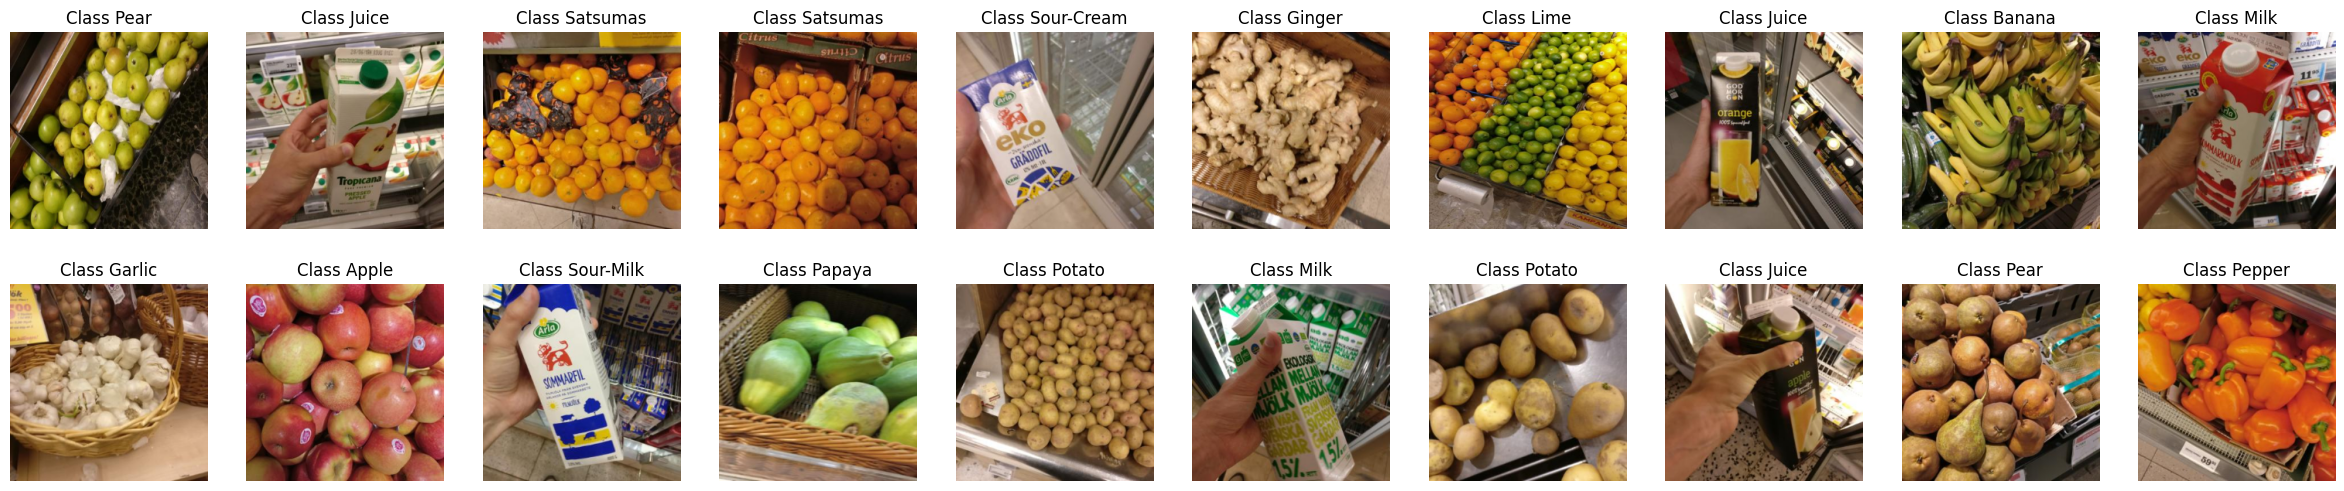

In [16]:
fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel()
for i in range(20):
    rand_idx = np.random.randint(0, X_train.shape[0])
    ax[i].set_axis_off()
    ax[i].set_title(f"Class {labels_coarse[y_train[rand_idx]]}")
    ax[i].imshow(cv2.cvtColor(X_train[rand_idx], cv2.COLOR_BGR2RGB))

<h1 style='font-family:TimesNewRoman'>1. Building a network from scratch</h1>

<div style='text-align: justify; font-family:TimesNewRoman'>

After retreiving the dataset, a quick inspection reveals the pictures are of size 256x256, each having 3 channels. Throughout this first step, only the training and validation datasets are used, totalling to ~3000 pictures. The first iteration of the CNN was the most basic possible, so no action was performed on the training or the validation dataset (i.e. no data augmentation and no data normalisation).
</div>

<h2 style='font-family:TimesNewRoman'>1.1 Model structure</h2> 

<div style='text-align: justify; font-family:TimesNewRoman'>

The model used in this basic iteration had 3 layers, 2 being 3x3 convolutional layers and the last being an FC layer for classification, identical to the network seen in the lab lesson. The convolutional layers employ no stride and the padding necessary not to reduce the activation size. The downsampling is obtained through some max-pooling steps following every convolutional layer. Note that, when the spatial size of the activation is reduced, the number of channels of the activation is increased.

The follwoing snippet of code contains the network definition as well as the `summary` method.
</div>

In [28]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

input_shape = X_train.shape[1:]

model = Sequential(
    [   
        # Input layer.
        Input(shape = input_shape),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │      11,272,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,291,627 (43.07 MB)

 Trainable params: 11,291,627 (43.07 MB)

 Non-trainable params: 0 (0.00 B)

<h2 style='font-family:TimesNewRoman'>1.2 Model training</h2> 

In [18]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 64 #128
epochs = 8
val_split_percentage = 0.25

model.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model.fit(
    X_train, 
    y_train,
    batch_size = batch_size, 
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

Epoch 1/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.1587 - loss: 99.9163 - val_accuracy: 0.1757 - val_loss: 3.5464
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.6356 - loss: 1.4655 - val_accuracy: 0.1081 - val_loss: 4.9257
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.9144 - loss: 0.3753 - val_accuracy: 0.1486 - val_loss: 7.6285
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9833 - loss: 0.0693 - val_accuracy: 0.1284 - val_loss: 9.7715
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9932 - loss: 0.0318 - val_accuracy: 0.1216 - val_loss: 11.6681
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9898 - loss: 0.0439 - val_accuracy: 0.1757 - val_loss: 11.4534
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9996 - loss: 0.0041 - val_accuracy: 0.1318 - val_loss: 12.3055
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.1554 - val_l

<h2 style='font-family:TimesNewRoman'>1.3 Model evaluation</h2> 

78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 331ms/step - accuracy: 0.2044 - loss: 11.1916
The test loss is 11.1916, the test accuracy is 0.2044.


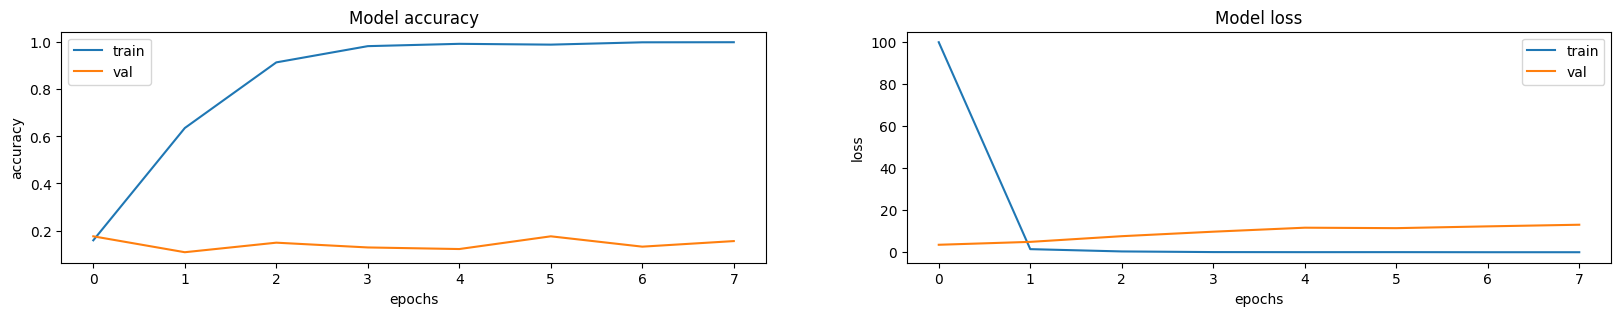

In [19]:
plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i + 1) 
    plt.plot(model.history.history[metric])
    plt.plot(model.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

test_loss, test_metric = model.evaluate(X_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

In [20]:
pred = model.predict(X_test)
print("Test Input Shape: {} Test output shape: {}".format(X_test.shape, pred.shape))

78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 308ms/step
Test Input Shape: (2485, 256, 256, 3) Test output shape: (2485, 43)


In [21]:
pred = np.argmax(pred, axis = -1)
print(pred)

[13  0 13 ... 13 19 20]


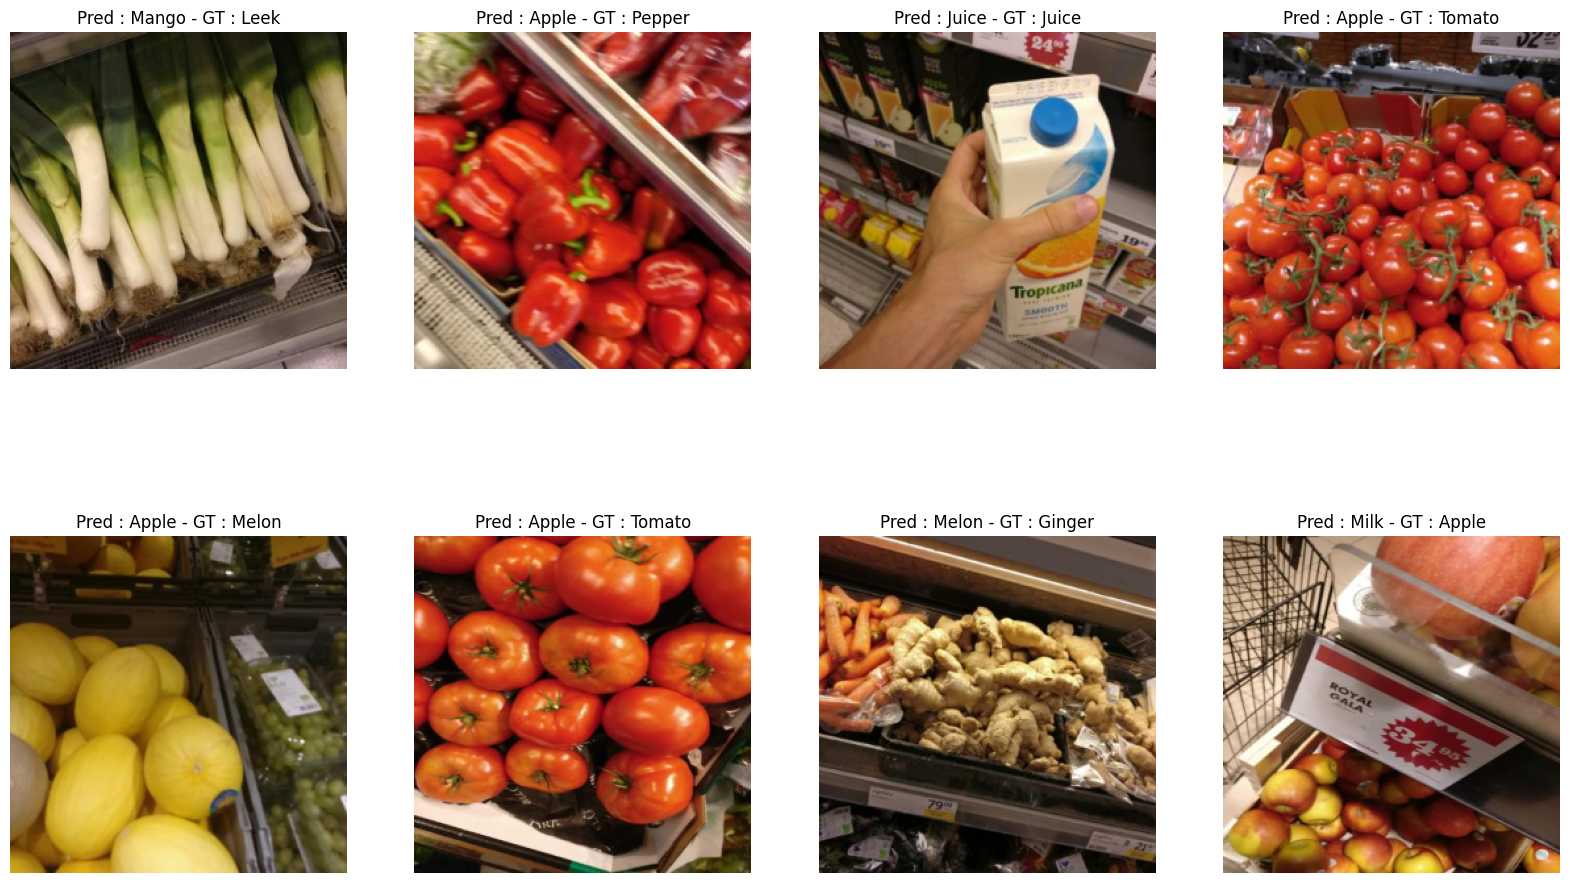

In [24]:
plt.figure(figsize=(20,12))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    rand_idx = np.random.randint(0, X_test.shape[0])
    plt.axis('off')
    plt.title(f"Pred : {labels_coarse[pred[rand_idx]]} - GT : {labels_coarse[y_test[rand_idx]]}")
    plt.imshow(cv2.cvtColor(X_test[rand_idx], cv2.COLOR_BGR2RGB))
plt.show()

<div style='text-align: justify; font-family:TimesNewRoman'>

The results show a relatively low validation accuracy (~15%), paired with an almost 100% accuracy on the training set. Presumably, the model is
currently **overfitting**. This may be either due to an excessive model capacity or an insufficient amount of pictures in the training dataset. Given the overall simple nature of the model, the former is excluded. Hence, the size of the training dataset was increased in the following iteration.
</div>

<h2 style='font-family:TimesNewRoman'>1.4 Second iteration</h2>

<div style='text-align: justify; font-family:TimesNewRoman'>

To fix the overfitting tendency, data augmentation was introduced. The augmentation emplyed performs the following transformations on the pictures:

</div>